## General variable Information

    1. VendorID - A code indicating the TPEP provider that provided the  record. [ 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc. ]
  
    2. tpep_pickup_datetime - The date and time when the meter was engaged.
    
    3. tpep_dropoff_datetime - The date and time when the meter was disengaged.
    
    4. Passenger_count - The number of passengers in the vehicle. This is a driver-entered value.
    
    5. Trip_distance - The elapsed trip distance in miles reported by the taximeter.
    
    6. Pickup_longitude - Longitude where the meter was engaged.
    
    7. Pickup_latitude - Latitude where the meter was engaged.
    
    8. RateCodeID - The final rate code in effect at the end of the trip. [ 1= Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride ]
    
    9. Store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. [ Y= store and forward trip, N= not a store and forward trip ]
    
    10. Dropoff_longitude - Longitude where the meter was disengaged.
    
    11. Dropoff_ latitude - Latitude where the meter was disengaged.
    
    12. Payment_type - A numeric code signifying how the passenger paid for the trip. [ 1= Credit card, 2= Cash, 3= No charge, 4= Dispute, 5= Unknown, 6= Voided trip ]
    
    13. Fare_amount - The time-and-distance fare calculated by the meter.
    
    14. Extra - Miscellaneous extras and surcharges. Currently, this only includes the $0.50 and $1 rush hour and overnight charges.

    15. MTA_tax - $0.50 MTA tax that is automatically triggered based on the metered rate in use.
    
    16. Improvement_surcharge - $0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.
    
    17. Tip_amount - This field is automatically populated for credit card tips. Cash tips are not included.
    
    18. Tolls_amount - Total amount of all tolls paid in trip.

    19. Total_amount - The total amount charged to passengers. Does not include cash tips.

## Week 1. Solution.

In [41]:
import numpy as np
import pandas as pd

#### 1. Загрузите данные за май 2016 года.

In [42]:
regions = pd.read_csv("regions.csv", sep=";")
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [43]:
data_05_2016_raw = pd.read_csv('D:/Data/yellow_tripdata_2016-05.csv')

In [44]:
pickup_hour = [data_05_2016_raw['tpep_pickup_datetime'][i][11:13] for i in data_05_2016_raw.index]

In [45]:
data_05_2016_raw.insert(1, 'pickup_hour', pickup_hour)
data_05_2016_raw.insert(2, 'count', [1]*data_05_2016_raw.shape[0]) # добавим столбец из единиц для последующего аггрегирования

#### 2. Проведите фильтрацию: удалите поездки с

    1) нулевой длительностью
    2) нулевым количеством пассажиров
    3) нулевым расстоянием поездки по счётчику
    4) координатами начала, не попадающими в прямоугольник Нью-Йорка

In [46]:
data_05_2016 = data_05_2016_raw[(data_05_2016_raw.trip_distance>0.0) & (data_05_2016_raw.passenger_count>0) &
                                (data_05_2016_raw.fare_amount>0.0) & 
                                (-74.25559<data_05_2016_raw.pickup_longitude) & (data_05_2016_raw.pickup_longitude<-73.70001) &
                                (40.49612<data_05_2016_raw.pickup_latitude) & (data_05_2016_raw.pickup_latitude<40.91553)]

#### 3. Агрегируйте данные за май 2016 года по часам и областям (можно использовать функцию stats.binned_statistic_2d, с которой вы сталкивались в заданиях четвёртого курса). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.

In [47]:
class set_region():
    west_borders = -74.25559 # left
    east_borders = -73.70001 # right
    south_borders = 40.49612 # bottom
    north_borders = 40.91553 # up

    intervals_cnt = 50
    regions_cnt = intervals_cnt*intervals_cnt
    dx = (east_borders-west_borders)/intervals_cnt
    dy = (north_borders-south_borders)/intervals_cnt    
    
region_x = ((data_05_2016.pickup_longitude-set_region.west_borders)/set_region.dx).astype(np.int)
region_y = ((data_05_2016.pickup_latitude-set_region.south_borders)/set_region.dy).astype(np.int)
region_id = region_x*set_region.intervals_cnt+region_y+1
data_05_2016['region'] = region_id

C:\Users\PDudukin\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [70]:
data_05_2016[(data_05_2016.region<1) | (data_05_2016.region>2500)] # check

,region,pickup_hour,count


#### 4. Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

In [49]:
data_05_2016.head()

,VendorID,pickup_hour,count,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,...,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,region
0,1,00,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,...,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80,1233
1,2,00,1,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,...,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68,1180
2,2,00,1,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,...,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36,1180
3,2,00,1,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,...,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96,1173
4,2,00,1,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,...,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76,1130


In [50]:
data_05_2016 = data_05_2016.iloc[:][['region','pickup_hour', 'count']]

In [51]:
data_05_2016.head()

,region,pickup_hour,count
0,1233,00,1
1,1180,00,1
2,1180,00,1
3,1173,00,1
4,1130,00,1


In [52]:
data = data_05_2016[['region','pickup_hour', 'count']].groupby(['region','pickup_hour']).agg(['count'])

In [53]:
data.head()

,,count
,,count
region,pickup_hour,
15,13,1
16,08,1
25,13,1
27,03,1
32,11,1


#### 5. Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

In [54]:
# Загуглим координаты Empire State Building: 40.7484° N, 73.9857° W
ESB_latitude = 40.7484
ESB_longitude = 73.9857

# Найдем ID соответствующего региона
for i in range(regions['region'].shape[0]):
    if ((regions.west[i]<-ESB_longitude<regions.east[i]) & (regions.south[i]<ESB_latitude<regions.north[i])):
        ESB_regionID = regions.region[i]
        print ESB_regionID
    else:
        continue

1231


In [55]:
data = data.reset_index()

In [56]:
data.head()

,region,pickup_hour,count
,,,count
0,15,13,1
1,16,08,1
2,25,13,1
3,27,03,1
4,32,11,1


In [57]:
data.columns = data.columns.droplevel(1)

In [58]:
data.head()

,region,pickup_hour,count
0,15,13,1
1,16,08,1
2,25,13,1
3,27,03,1
4,32,11,1


In [59]:
ESB_hour = data[data.region==ESB_regionID].pickup_hour
ESB_count = data[data.region==ESB_regionID]['count']

ESB_hour = ESB_hour.values
ESB_count = ESB_count.values

In [60]:
% matplotlib inline
import matplotlib.pyplot as plt

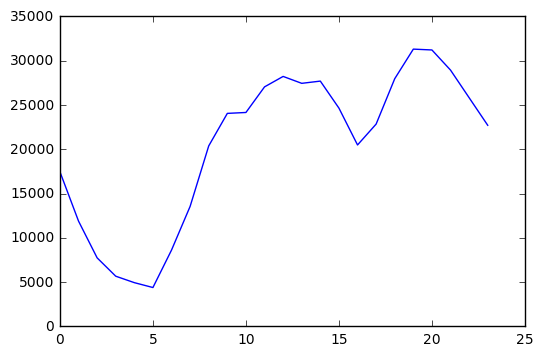

In [61]:
plt.plot(ESB_hour, ESB_count)

#### 6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [67]:
region_x = ((data_05_2016_raw.pickup_longitude-set_region.west_borders)/set_region.dx).astype(np.int)
region_y = ((data_05_2016_raw.pickup_latitude-set_region.south_borders)/set_region.dy).astype(np.int)
region_id_raw = region_x*set_region.intervals_cnt+region_y+1
data_05_2016_raw['region'] = region_id_raw

In [76]:
ind = data_05_2016_raw[(data_05_2016_raw.region<1) | (data_05_2016_raw.region>2500)].index # check

In [ ]:
data_05_2016_raw_upd = data_05_2016_raw.drop(ind) # дропнем индексы с кривыми айдишниками регионов, посчитанными в предыдущей ячейке

In [80]:
# Посчитаем количество различных уникальных регионов в которых были заказы желтых такси в Нью-Йорке

uar = len(set(data_05_2016_raw_upd.region))

# Посчитаем количество различных уникальных регионов в агрегированных данных
uar_agg = len(set(data.region))

# Посчитаем ответ на задание (24 - часов в дне)
print 24*(uar - uar_agg)

10320
